### Imports

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np

In [2]:
import random

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Utils

In [3]:
def relu(x):
    return x.clamp(min=0) # max(x, 0)

In [4]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x)) # 1/(1 + e^-x)

In [5]:
def mse_loss(y_, y):
    diff = y_ - y # pred - target
    return (diff * diff).mean()

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Q1

### Initialize

In [ ]:
def xavier_init(in_dim, out_dim):
    std = (2.0 / (in_dim + out_dim)) ** 0.5
    return torch.randn(in_dim, out_dim) * std # xavier initialisation

def init_params(latent_dim=16):
    params = {}

    enc_W1 = xavier_init(784, 256)
    enc_b1 = torch.zeros(256)
    enc_W2 = xavier_init(256, latent_dim)
    enc_b2 = torch.zeros(latent_dim)
    dec_W3 = xavier_init(latent_dim, 256)
    dec_b3 = torch.zeros(256)
    dec_W4 = xavier_init(256, 784)
    dec_b4 = torch.zeros(784)

    for name, tensor in zip(
        ['enc_W1', 'enc_b1', 'enc_W2', 'enc_b2', 'dec_W3', 'dec_b3', 'dec_W4', 'dec_b4'],
        [enc_W1, enc_b1, enc_W2, enc_b2, dec_W3, dec_b3, dec_W4, dec_b4]
    ):
        params[name] = tensor.detach().clone().requires_grad_() # Register with auto grad

    return params

# Model Arch

In [ ]:
def encode(x, params):
    # Flatten - [batch_size, 784]
    y = x.view(x.size(0), -1)

    # Encoder - [batch_size, 256]
    z = relu(y @ params['enc_W1'] + params['enc_b1'])

    # Latent Space - [batch_size, latent_dim]
    z = relu(z @ params['enc_W2'] + params['enc_b2'])

    return z

def decode(x, params):
    # Decoder Layer - [batch_size, 256]
    y = relu(x @ params['dec_W3'] + params['dec_b3'])

    # Reconstruction - [batch_size, 784]
    z = sigmoid(y @ params['dec_W4'] + params['dec_b4'])

    return z

def forward(x, params):

    y = encode(x, params)
    z = decode(y, params)
    return z, y # reconstructed, latents

# Training

In [ ]:
def train(params, train_loader, test_loader, epochs=10, device='cpu'):
    for key in params:
        params[key].data = params[key].data.to(device) #offload to gpu

    optimizer = torch.optim.Adam(list(params.values()), lr=1e-3) # Optimizer
    train_losses, test_losses = [], [] # To plot

    # Training
    for epoch in range(epochs):
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            optimizer.zero_grad() # Set to 0 grad
            z, _ = forward(x, params) # Forward Prop
            loss = mse_loss(z, x.view(x.size(0), -1)) # Compute Loss
            loss.backward() # Back prop
            optimizer.step()
            total_loss += loss.item() * x.size(0)

        train_loss = total_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Test loss
        with torch.no_grad():
            test_total = 0
            for x, _ in test_loader:
                x = x.to(device)
                z, _ = forward(x, params) # Forward Pass
                loss = mse_loss(z, x.view(x.size(0), -1)) # Compute Los
                test_total += loss.item() * x.size(0)

            test_loss = test_total / len(test_loader.dataset)
            test_losses.append(test_loss)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

    return params

In [ ]:
def reconstruct(params, data_loader, device='cpu', n=8):
    for key in params:
        params[key].data = params[key].data.to(device) #offload to gpu

    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            z, _ = forward(x, params) # Encode + Decode
            break

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray') # Original
        axes[0, i].axis('off')
        axes[1, i].imshow(z[i].view(28, 28).cpu(), cmap='gray') # Output
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()

In [ ]:
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

Epoch 1: Train Loss = 0.0323, Test Loss = 0.0197
Epoch 2: Train Loss = 0.0181, Test Loss = 0.0171
Epoch 3: Train Loss = 0.0164, Test Loss = 0.0158
Epoch 4: Train Loss = 0.0153, Test Loss = 0.0150
Epoch 5: Train Loss = 0.0145, Test Loss = 0.0142
Epoch 6: Train Loss = 0.0139, Test Loss = 0.0138
Epoch 7: Train Loss = 0.0135, Test Loss = 0.0134
Epoch 8: Train Loss = 0.0132, Test Loss = 0.0133
Epoch 9: Train Loss = 0.0130, Test Loss = 0.0131
Epoch 10: Train Loss = 0.0128, Test Loss = 0.0129
Epoch 11: Train Loss = 0.0126, Test Loss = 0.0127
Epoch 12: Train Loss = 0.0124, Test Loss = 0.0126
Epoch 13: Train Loss = 0.0123, Test Loss = 0.0123
Epoch 14: Train Loss = 0.0121, Test Loss = 0.0123
Epoch 15: Train Loss = 0.0119, Test Loss = 0.0121
Epoch 16: Train Loss = 0.0118, Test Loss = 0.0120
Epoch 17: Train Loss = 0.0117, Test Loss = 0.0120
Epoch 18: Train Loss = 0.0116, Test Loss = 0.0118
Epoch 19: Train Loss = 0.0116, Test Loss = 0.0118
Epoch 20: Train Loss = 0.0115, Test Loss = 0.0117
Training‑

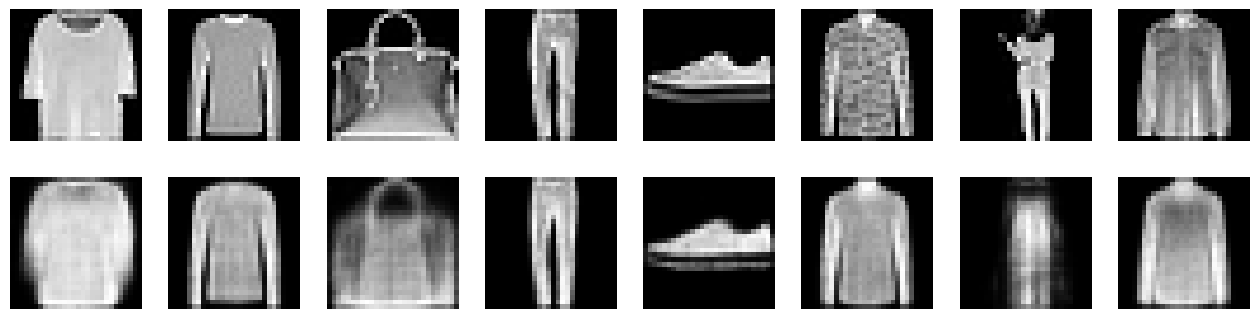

Test‑set reconstructions


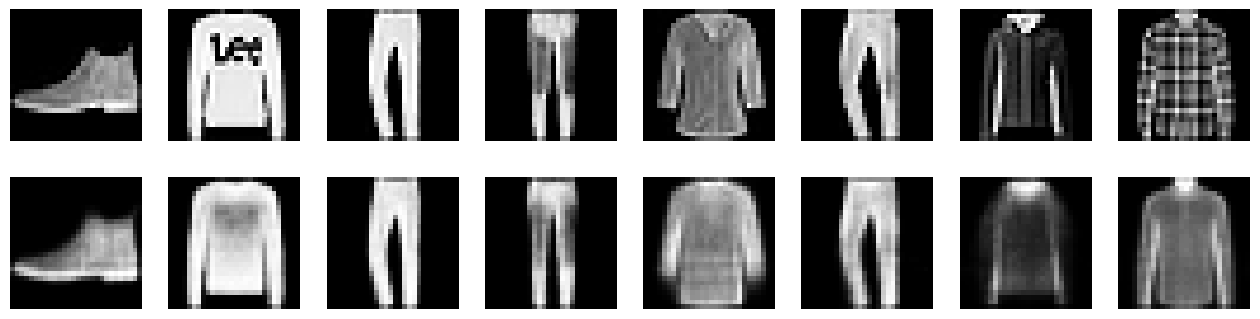

In [ ]:
# 16 Dim
auto_encoder_16 = init_params(latent_dim=16)
auto_encoder_16 = train(auto_encoder_16, train_loader, test_loader, epochs=20, device=device) # training
print("Training‑set reconstructions")
reconstruct(auto_encoder_16, train_loader, device=device)
print("Test‑set reconstructions")
reconstruct(auto_encoder_16, test_loader, device=device)

#### 16 dimensional bottleneck

- Shape is preserved, but fine details are lost.

- The shoe's overall profile remains, but the stitching and tread texture vanishes.

- The sweatshirt keeps its outline, yet text/logos are blurred away.

- High frequency features (stripes, labels, collars) are replaced by smooth gradients.


With only 16 latent features it has less capacity to encode both global structure and fine texture.

Epoch 1: Train Loss = 0.0300, Test Loss = 0.0174
Epoch 2: Train Loss = 0.0150, Test Loss = 0.0135
Epoch 3: Train Loss = 0.0129, Test Loss = 0.0130
Epoch 4: Train Loss = 0.0116, Test Loss = 0.0113
Epoch 5: Train Loss = 0.0109, Test Loss = 0.0107
Epoch 6: Train Loss = 0.0103, Test Loss = 0.0102
Epoch 7: Train Loss = 0.0099, Test Loss = 0.0099
Epoch 8: Train Loss = 0.0096, Test Loss = 0.0095
Epoch 9: Train Loss = 0.0094, Test Loss = 0.0093
Epoch 10: Train Loss = 0.0092, Test Loss = 0.0092
Epoch 11: Train Loss = 0.0090, Test Loss = 0.0090
Epoch 12: Train Loss = 0.0089, Test Loss = 0.0089
Epoch 13: Train Loss = 0.0087, Test Loss = 0.0088
Epoch 14: Train Loss = 0.0086, Test Loss = 0.0086
Epoch 15: Train Loss = 0.0085, Test Loss = 0.0086
Epoch 16: Train Loss = 0.0084, Test Loss = 0.0084
Epoch 17: Train Loss = 0.0083, Test Loss = 0.0084
Epoch 18: Train Loss = 0.0082, Test Loss = 0.0084
Epoch 19: Train Loss = 0.0081, Test Loss = 0.0083
Epoch 20: Train Loss = 0.0081, Test Loss = 0.0082
Training‑

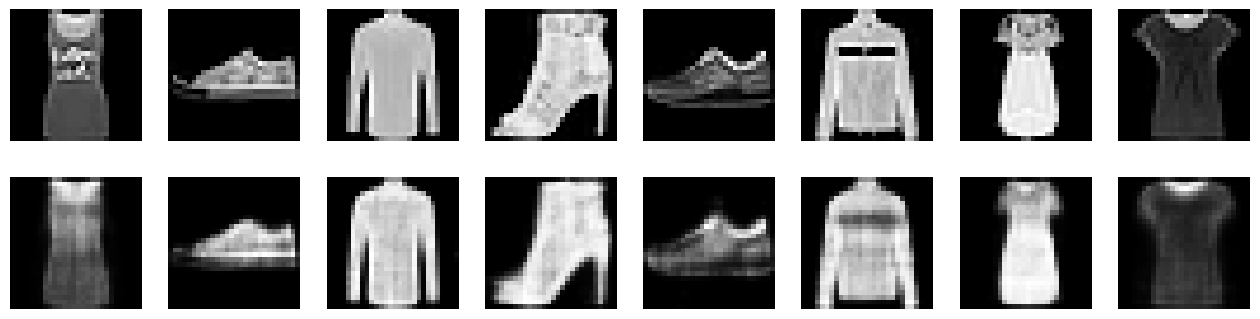

Test‑set reconstructions


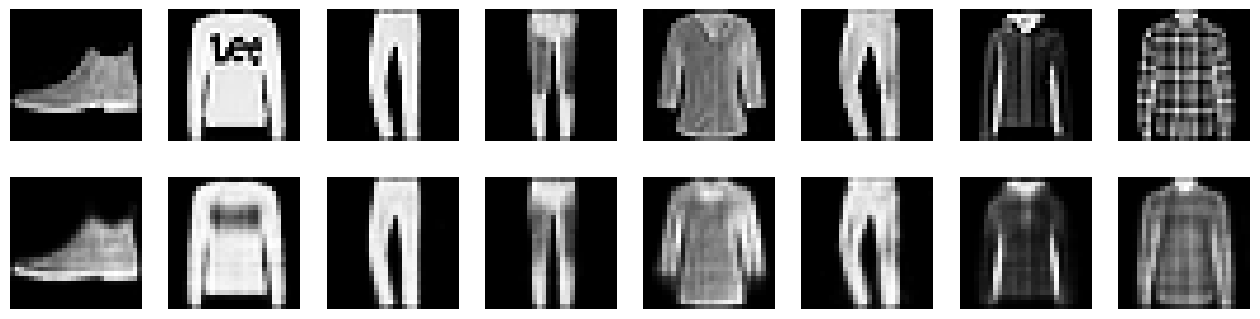

In [ ]:
# 48 Dim
auto_encoder_48 = init_params(latent_dim=48)
auto_encoder_48 = train(auto_encoder_48, train_loader, test_loader, epochs=20, device=device)
print("Training‑set reconstructions")
reconstruct(auto_encoder_48, train_loader, device=device)
print("Test‑set reconstructions")
reconstruct(auto_encoder_48, test_loader, device=device)

#### 48 Dimensional Bottleneck

Sharp edges and fine textures are now preserved:

- The shoe's stitching and shading reappear.
- The sweatshirt's logo/text is legible again

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def linear_interpolation(params, loader, pairs=4, steps=5, title_prefix="Latent"):
    for k in params:
        params[k].data = params[k].data.to(device) # offload to gpu

    imgs, _ = next(iter(loader))
    imgs, _ = next(iter(loader)) # Taking a batch
    imgs = imgs.to(device)

    z_all = encode(imgs, params)

    for i in range(pairs):
        z1, z2 = z_all[2*i], z_all[2*i + 1] # Pick a pair
        fig, axes = plt.subplots(1, steps, figsize=(steps*1.8, 2))
        for j, a in enumerate(np.linspace(0, 1, steps)):
            z = (1-a)*z1 + a*z2 # Linear Interpolation
            y = decode(z.unsqueeze(0), params)      # [1,784]
            axes[j].imshow(y.view(28,28).cpu().detach().numpy(), cmap='gray') # Show image
            axes[j].axis('off')
        fig.suptitle(f"{title_prefix} Dim ― Pair #{i+1}")
        plt.show()

Interpolation for latent_dim = 16


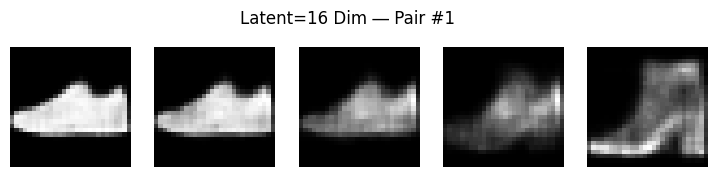

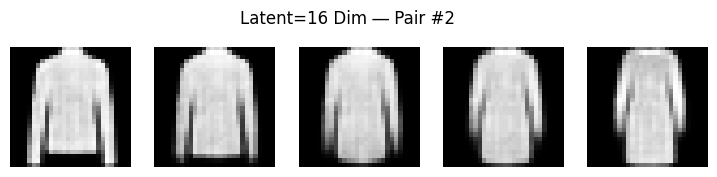

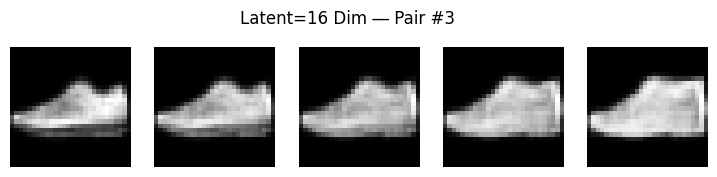

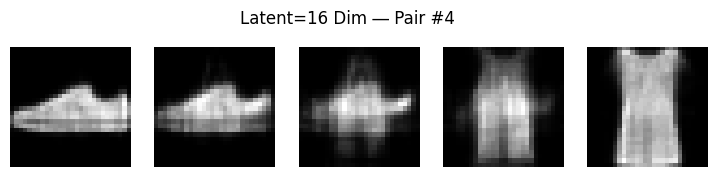

Interpolation for latent_dim = 48


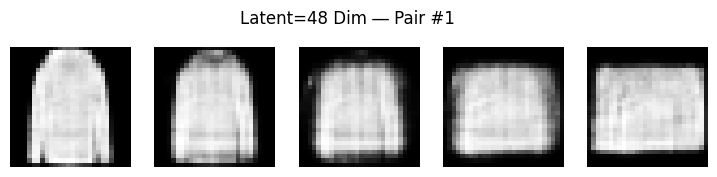

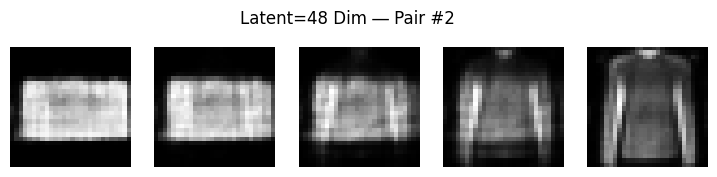

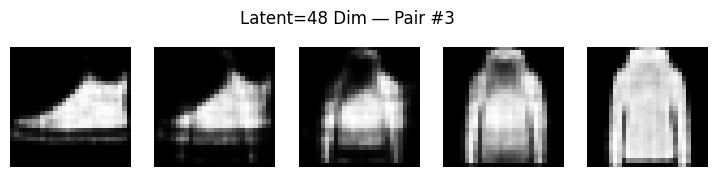

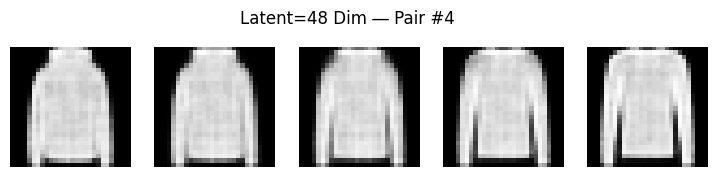

In [ ]:
print("Interpolation for latent_dim = 16")
linear_interpolation(auto_encoder_16, train_loader, pairs=4, steps=5, title_prefix="Latent=16")

print("Interpolation for latent_dim = 48")
linear_interpolation(auto_encoder_48, train_loader, pairs=4, steps=5, title_prefix="Latent=48")

1. Majority are either variations of shoes or sweaters.

2. wont suddenly see a dress or a bag in the middle. it will be a transition


3. If latent space is small (16 dims), the transition blurs out fine details (stitching, logos).

4. With more capacity (48 dims+), even mid frames show clear seams, patterns, textures.


5. Every intermediate image looks a mix of the two images.
6. Some cases when both shoes and sweater is present a mixed variation of both these are seen

# Q2

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # flatten
])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.93MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.3MB/s]


In [8]:
def binary_cross_entropy(y_, y, eps=1e-8): # pred, target
    y_ = torch.clamp(y_, eps, 1 - eps)  # avoid log(0)
    loss = y * torch.log(y_) + (1 - y) * torch.log(1 - y_)
    return -loss.sum()

In [9]:
def vae_loss(x, x_recon, mu, logvar):
    bce = binary_cross_entropy(x_recon, x)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (bce + kl) / x.size(0)  # return average per batch

In [10]:
def init_params(latent_dim=12):
    params = {}
    input_dim, hidden_dim = 784, 400

    # Encoder
    enc_W1 = torch.randn(hidden_dim, input_dim) * 0.01
    enc_b1 = torch.zeros(hidden_dim)

    # Encoder for mu and logvar
    enc_mu_W     = torch.randn(latent_dim, hidden_dim) * 0.01
    enc_mu_b     = torch.zeros(latent_dim)
    enc_logvar_W = torch.randn(latent_dim, hidden_dim) * 0.01
    enc_logvar_b = torch.zeros(latent_dim)

    # Decoder
    dec_W3 = torch.randn(hidden_dim, latent_dim) * 0.01
    dec_b3 = torch.zeros(hidden_dim)
    dec_W4 = torch.randn(input_dim, hidden_dim) * 0.01
    dec_b4 = torch.zeros(input_dim)

    names = [
        'enc_W1','enc_b1',
        'enc_mu_W','enc_mu_b','enc_logvar_W','enc_logvar_b',
        'dec_W3','dec_b3','dec_W4','dec_b4'
    ]
    tensors = [
        enc_W1, enc_b1,
        enc_mu_W, enc_mu_b, enc_logvar_W, enc_logvar_b,
        dec_W3, dec_b3, dec_W4, dec_b4
    ]
    for name, t in zip(names, tensors):
        params[name] = t.detach().clone().requires_grad_() # Register in Autograd

    return params

params = init_params()

for key in params:
    params[key].data = params[key].data.to(device) #offload to gpu

In [11]:
def encoder(x, params):
    h = relu(torch.matmul(x, params['enc_W1'].t()) + params['enc_b1']) # ReLU(W.T * b)
    mu = torch.matmul(h, params['enc_mu_W'].t()) + params['enc_mu_b']
    logvar = torch.matmul(h, params['enc_logvar_W'].t()) + params['enc_logvar_b']
    return mu, logvar

def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

def decoder(z, params):
    h = relu(torch.matmul(z, params['dec_W3'].t()) + params['dec_b3'])
    y = sigmoid(torch.matmul(h, params['dec_W4'].t()) + params['dec_b4']) # reconstruct
    return y

In [12]:
import torch.optim as optim

optimizer = optim.Adam([p for p in params.values()], lr=1e-3)

# Training
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)

        # Forward prop
        mu, logvar = encoder(x, params)
        z = reparameterize(mu, logvar)
        y = decoder(z, params)

        # Compute loss
        loss = vae_loss(x, y, mu, logvar)
        total_loss += loss.item() * x.size(0)

        # Backprop + update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(train_loader.dataset)

    with torch.no_grad():
        test_total = 0
        for x, _ in test_loader:
            x = x.to(device)

            mu, logvar = encoder(x, params)
            z = reparameterize(mu, logvar)
            y = decoder(z, params)

            loss = vae_loss(x, y, mu, logvar)
            test_total += loss.item() * x.size(0)

        test_loss = test_total / len(test_loader.dataset)

    print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1, Train Loss: 310.3277, Test Loss: 267.3554
Epoch 2, Train Loss: 260.6666, Test Loss: 256.2270
Epoch 3, Train Loss: 253.8148, Test Loss: 251.5300
Epoch 4, Train Loss: 250.0568, Test Loss: 248.5908
Epoch 5, Train Loss: 247.8081, Test Loss: 247.2174
Epoch 6, Train Loss: 246.5682, Test Loss: 245.8040
Epoch 7, Train Loss: 245.5945, Test Loss: 244.9145
Epoch 8, Train Loss: 244.8404, Test Loss: 244.3310
Epoch 9, Train Loss: 244.1850, Test Loss: 243.7852
Epoch 10, Train Loss: 243.6475, Test Loss: 243.1199


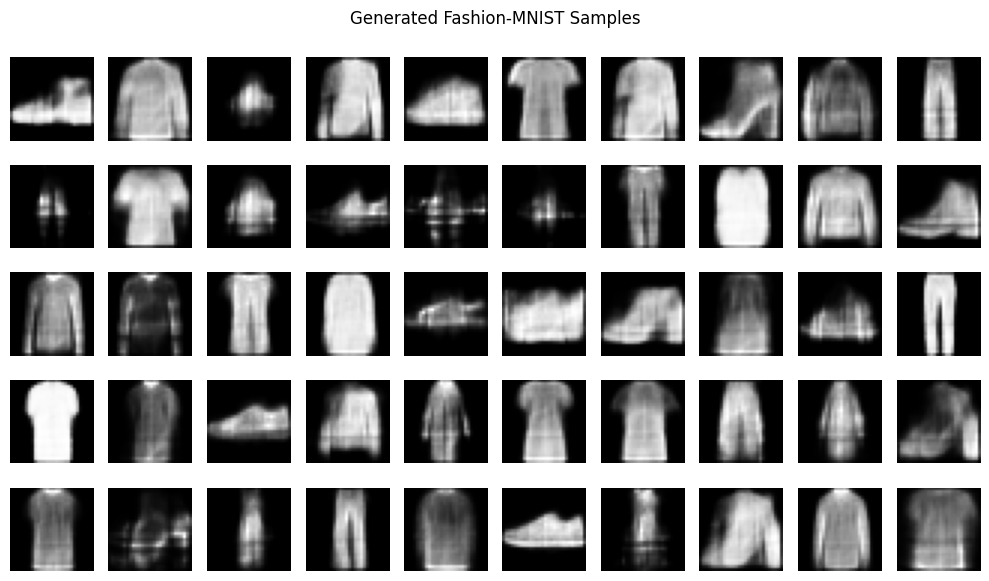

In [13]:
def sample(params, num_samples=50):
    latent_dim = 12
    z = torch.randn(num_samples, latent_dim, device=device) # Random Noise
    samples = decoder(z, params) # Decode latents to Images
    samples = samples.view(-1, 28, 28).cpu().detach().numpy()

    # Plot
    plt.figure(figsize=(10, 6))
    for i in range(num_samples):
        plt.subplot(5, 10, i+1)
        plt.imshow(samples[i], cmap='gray')
        plt.axis('off')
    plt.suptitle("Generated Fashion-MNIST Samples")
    plt.tight_layout()
    plt.show()

sample(params)

1. diverse multiple classes of images are generated (shoes, tops etc), among them shoes are of different types like boots, low shoes etc. tops are normal sleeves, full sleeves etc

2. overall shape is legit and features are distinct but finer details like logo etc are absent

3. despite the blur, we can say sample belongs to a valid Fashion MNIST category.

4. Able to generate new cloth/fashion like images

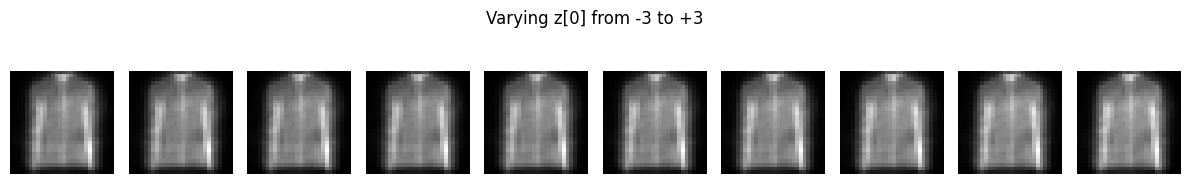

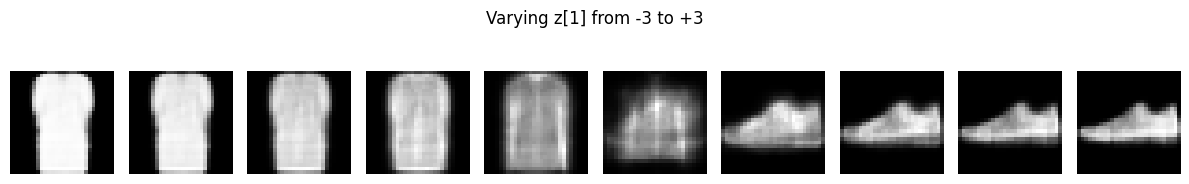

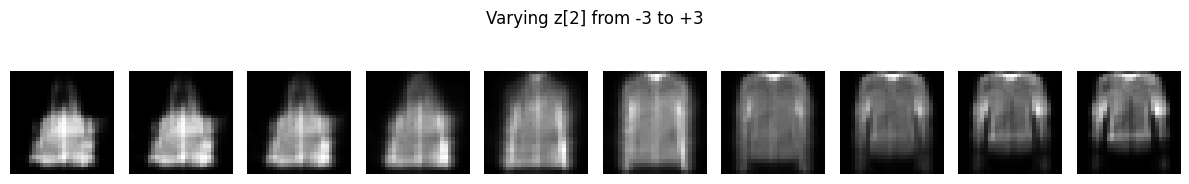

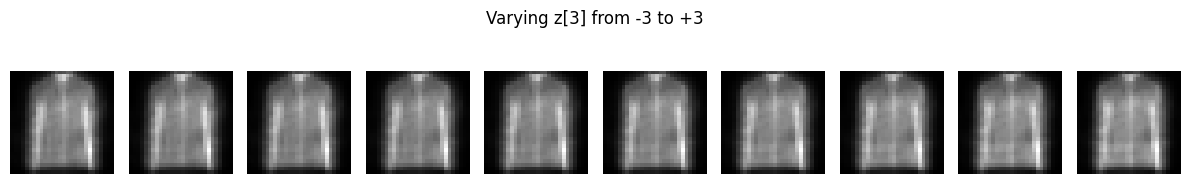

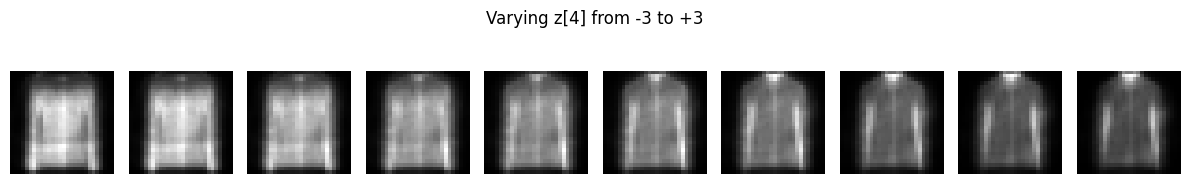

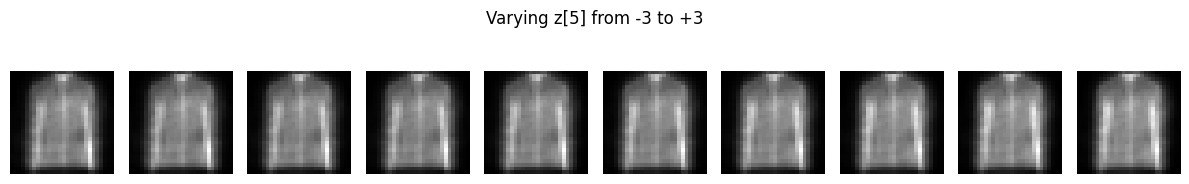

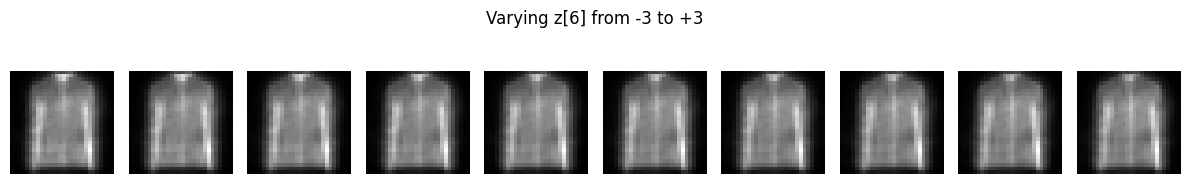

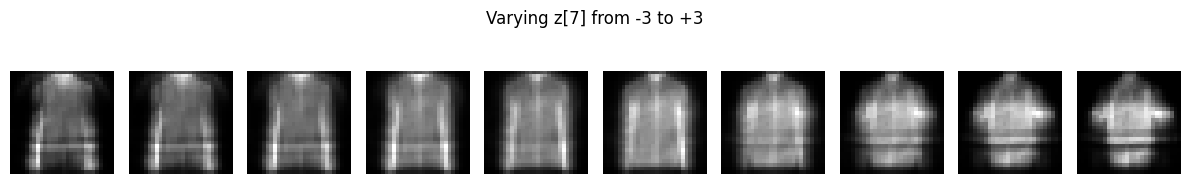

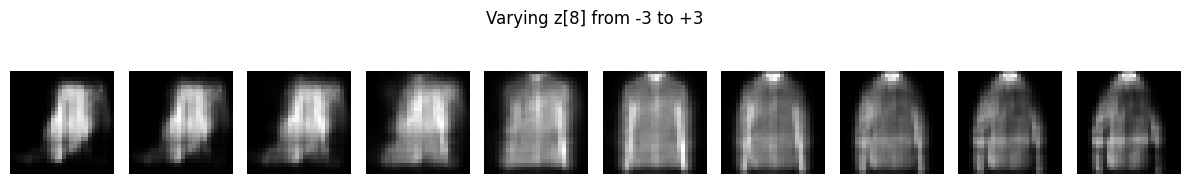

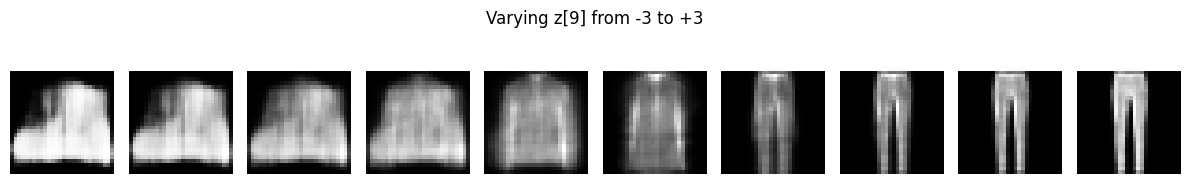

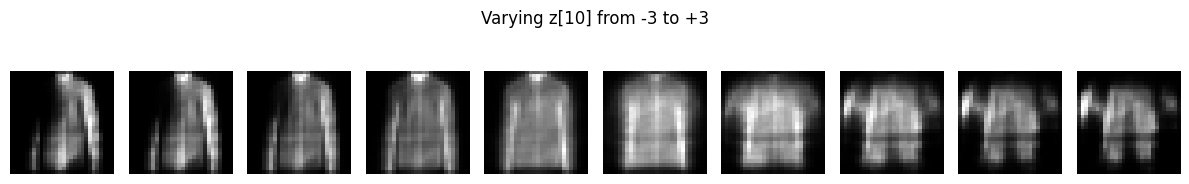

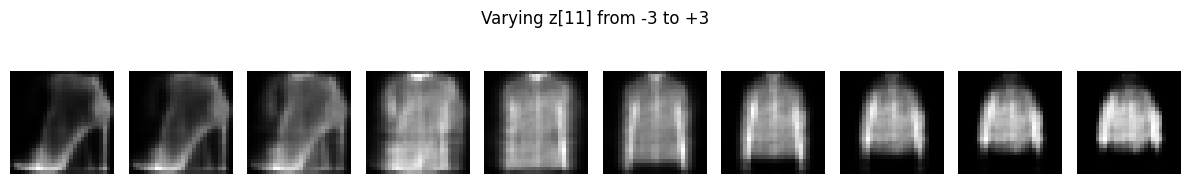

In [14]:
def tweak_latents(params, dim=0, steps=10, z_fixed=None):
    latent_dim = 12
    values = torch.linspace(-3, 3, steps).to(device)


    if z_fixed is None:
        z_base = torch.zeros((steps, latent_dim), device=device)
    else:
        z_base = z_fixed.repeat(steps, 1)

    z_base[:, dim] = values # Append Dimension


    images = decoder(z_base, params).view(-1, 28, 28).cpu().detach().numpy()


    plt.figure(figsize=(12, 2))
    for i in range(steps):
        plt.subplot(1, steps, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(f'Varying z[{dim}] from -3 to +3')
    plt.tight_layout()
    plt.show()


for d in range(12):
    tweak_latents(params, dim=d)

Tweaking the dimension alters the reconstructed image. The image grows, shrinks, brighten and darken. New cloth like images are obtained. Shapes becomes more redefined across dimensions.

# Q1 Manual backpropagation

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import numpy as np

In [ ]:
import random

seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Utils

In [ ]:
def relu(x):
    return x.clamp(min=0) # max(x, 0)

In [ ]:
def sigmoid(x):
    return 1 / (1 + torch.exp(-x)) # 1/(1 + e^-x)

In [ ]:
def mse_loss(y_, y):
    diff = y_ - y # pred - target
    return (diff * diff).mean()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Initialize

In [ ]:
def xavier_init(in_dim, out_dim):
    std = (2.0 / (in_dim + out_dim)) ** 0.5
    return torch.randn(in_dim, out_dim) * std # xavier initialisation

def init_params(latent_dim=16):
    params = {}

    enc_W1 = xavier_init(784, 256)
    enc_b1 = torch.zeros(256)
    enc_W2 = xavier_init(256, latent_dim)
    enc_b2 = torch.zeros(latent_dim)
    dec_W3 = xavier_init(latent_dim, 256)
    dec_b3 = torch.zeros(256)
    dec_W4 = xavier_init(256, 784)
    dec_b4 = torch.zeros(784)

    for name, tensor in zip(
        ['enc_W1', 'enc_b1', 'enc_W2', 'enc_b2', 'dec_W3', 'dec_b3', 'dec_W4', 'dec_b4'],
        [enc_W1, enc_b1, enc_W2, enc_b2, dec_W3, dec_b3, dec_W4, dec_b4]
    ):
        params[name] = tensor.detach().clone().requires_grad_() # Register with auto grad

    return params

# Model Arch

In [ ]:
def encode(x, params):
    # Flatten - [batch_size, 784]
    y = x.view(x.size(0), -1)

    # Encoder - [batch_size, 256]
    z = relu(y @ params['enc_W1'] + params['enc_b1'])

    # Latent Space - [batch_size, latent_dim]
    z = relu(z @ params['enc_W2'] + params['enc_b2'])

    return z

def decode(x, params):
    # Decoder Layer - [batch_size, 256]
    y = relu(x @ params['dec_W3'] + params['dec_b3'])

    # Reconstruction - [batch_size, 784]
    z = sigmoid(y @ params['dec_W4'] + params['dec_b4'])

    return z

def forward(x, params):

    y = encode(x, params)
    z = decode(y, params)
    return z, y # reconstructed, latents

# Training

In [ ]:
def train(params, train_loader, test_loader, epochs=10, lr=1e-3, device = device):
    
    for p in params.values():
        p.data = p.data.to(device)

    history = {'train_mse': [], 'test_mse': []}

    for ep in range(1, epochs+1):
        # TRAINING 
        train_sum = 0.0
        for x,_ in train_loader:
            B = x.size(0)
            x = x.to(device)
            x_flat = x.view(B, -1)                       # [B,784]

            #  Forward pass 
            pre1 = x_flat @ params['enc_W1'] + params['enc_b1']
            h1   = pre1.clamp(min=0)                     # ReLU

            pre2 = h1   @ params['enc_W2'] + params['enc_b2']
            z    = pre2.clamp(min=0)                     # ReLU

            pre3 = z    @ params['dec_W3'] + params['dec_b3']
            h2   = pre3.clamp(min=0)                     # ReLU

            pre4 = h2   @ params['dec_W4'] + params['dec_b4']
            x_hat = 1/(1 + torch.exp(-pre4))             # Sigmoid

            #  Loss 
            diff = x_hat - x_flat
            loss = (diff*diff).mean()
            train_sum += loss.item() * B

            #  Back‑prop 
            # dL/dx_hat
            d_xhat = (2.0/B) * diff

            
            sig_grad = x_hat*(1 - x_hat)
            delta4 = d_xhat * sig_grad                   # [B,784]

            # grads dec_W4, dec_b4
            gW4 = h2.t() @ delta4                        # [256,784]
            gb4 = delta4.sum(0)                          # [784]

            # back to h2
            dh2 = delta4 @ params['dec_W4'].t()          # [B,256]
            m3  = (pre3>0).float()
            delta3 = dh2 * m3                            # [B,256]

            # grads dec_W3, dec_b3
            gW3 = z.t() @ delta3                         # [latent,256]
            gb3 = delta3.sum(0)                          # [256]

            # back to z
            dz = delta3 @ params['dec_W3'].t()           # [B,latent]
            m2 = (pre2>0).float()
            delta2 = dz * m2                             # [B,latent]

            # grads enc_W2, enc_b2
            gW2 = h1.t() @ delta2                        # [256,latent]
            gb2 = delta2.sum(0)                          # [latent]

            # back to h1
            dh1 = delta2 @ params['enc_W2'].t()          # [B,256]
            m1  = (pre1>0).float()
            delta1 = dh1 * m1                            # [B,256]

            # grads enc_W1, enc_b1
            gW1 = x_flat.t() @ delta1                    # [784,256]
            gb1 = delta1.sum(0)                          # [256]

            # — Parameter updates (SGD) —
            params['dec_W4'].data -= lr * gW4
            params['dec_b4'].data -= lr * gb4
            params['dec_W3'].data -= lr * gW3
            params['dec_b3'].data -= lr * gb3
            params['enc_W2'].data -= lr * gW2
            params['enc_b2'].data -= lr * gb2
            params['enc_W1'].data -= lr * gW1
            params['enc_b1'].data -= lr * gb1

        history['train_mse'].append(train_sum/len(train_loader.dataset))

        # eval
        test_sum = 0.0
        with torch.no_grad():
            for x,_ in test_loader:
                B = x.size(0)
                x = x.to(device)
                x_flat = x.view(B, -1)
                # forward only
                h1 = (x_flat @ params['enc_W1'] + params['enc_b1']).clamp(min=0)
                z  = (h1     @ params['enc_W2'] + params['enc_b2']).clamp(min=0)
                h2 = (z      @ params['dec_W3'] + params['dec_b3']).clamp(min=0)
                x_hat = 1/(1 + torch.exp(-(h2 @ params['dec_W4'] + params['dec_b4'])))
                diff = x_hat - x_flat
                test_sum += (diff*diff).mean().item() * B

        history['test_mse'].append(test_sum/len(test_loader.dataset))
        print(f"Epoch {ep}/{epochs}  train MSE={history['train_mse'][-1]:.4f}  test MSE={history['test_mse'][-1]:.4f}")

    return params


In [ ]:
def reconstruct(params, data_loader, device='cpu', n=8):
    for key in params:
        params[key].data = params[key].data.to(device) #offload to gpu

    with torch.no_grad():
        for x, _ in data_loader:
            x = x.to(device)
            z, _ = forward(x, params) # Encode + Decode
            break

    fig, axes = plt.subplots(2, n, figsize=(n*2, 4))
    for i in range(n):
        axes[0, i].imshow(x[i].cpu().squeeze(), cmap='gray') # Original
        axes[0, i].axis('off')
        axes[1, i].imshow(z[i].view(28, 28).cpu(), cmap='gray') # Output
        axes[1, i].axis('off')
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Reconstructed")
    plt.show()

In [ ]:
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 298kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.58MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 23.5MB/s]


Epoch 1/20  train MSE=0.0839  test MSE=0.0525
Epoch 2/20  train MSE=0.0455  test MSE=0.0397
Epoch 3/20  train MSE=0.0362  test MSE=0.0328
Epoch 4/20  train MSE=0.0299  test MSE=0.0281
Epoch 5/20  train MSE=0.0269  test MSE=0.0256
Epoch 6/20  train MSE=0.0254  test MSE=0.0248
Epoch 7/20  train MSE=0.0243  test MSE=0.0239
Epoch 8/20  train MSE=0.0236  test MSE=0.0232
Epoch 9/20  train MSE=0.0229  test MSE=0.0224
Epoch 10/20  train MSE=0.0223  test MSE=0.0221
Epoch 11/20  train MSE=0.0219  test MSE=0.0217
Epoch 12/20  train MSE=0.0215  test MSE=0.0213
Epoch 13/20  train MSE=0.0211  test MSE=0.0209
Epoch 14/20  train MSE=0.0207  test MSE=0.0204
Epoch 15/20  train MSE=0.0204  test MSE=0.0201
Epoch 16/20  train MSE=0.0200  test MSE=0.0198
Epoch 17/20  train MSE=0.0198  test MSE=0.0196
Epoch 18/20  train MSE=0.0195  test MSE=0.0195
Epoch 19/20  train MSE=0.0192  test MSE=0.0192
Epoch 20/20  train MSE=0.0191  test MSE=0.0190


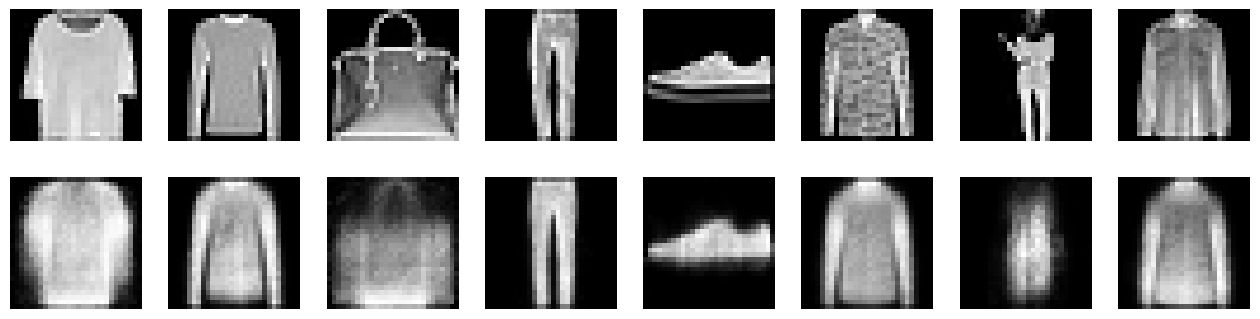

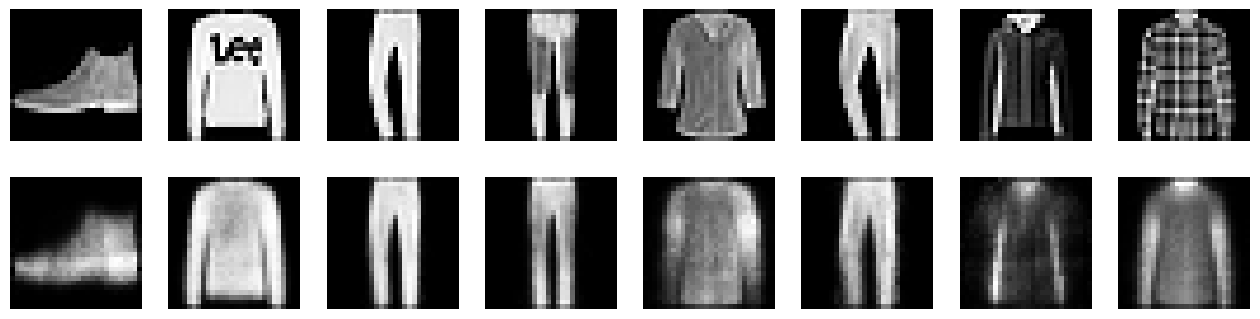

In [ ]:
# 16 Dim
auto_encoder_16 = init_params(latent_dim=16)
auto_encoder_16 = train(auto_encoder_16, train_loader, test_loader, epochs=20, device = device) # training
reconstruct(auto_encoder_16, train_loader, device=device)
reconstruct(auto_encoder_16, test_loader, device=device)

Epoch 1/20  train MSE=0.0758  test MSE=0.0486
Epoch 2/20  train MSE=0.0407  test MSE=0.0350
Epoch 3/20  train MSE=0.0314  test MSE=0.0286
Epoch 4/20  train MSE=0.0273  test MSE=0.0271
Epoch 5/20  train MSE=0.0254  test MSE=0.0247
Epoch 6/20  train MSE=0.0241  test MSE=0.0233
Epoch 7/20  train MSE=0.0231  test MSE=0.0229
Epoch 8/20  train MSE=0.0222  test MSE=0.0227
Epoch 9/20  train MSE=0.0214  test MSE=0.0210
Epoch 10/20  train MSE=0.0207  test MSE=0.0212
Epoch 11/20  train MSE=0.0202  test MSE=0.0198
Epoch 12/20  train MSE=0.0196  test MSE=0.0199
Epoch 13/20  train MSE=0.0192  test MSE=0.0189
Epoch 14/20  train MSE=0.0187  test MSE=0.0185
Epoch 15/20  train MSE=0.0184  test MSE=0.0183
Epoch 16/20  train MSE=0.0180  test MSE=0.0181
Epoch 17/20  train MSE=0.0176  test MSE=0.0178
Epoch 18/20  train MSE=0.0173  test MSE=0.0172
Epoch 19/20  train MSE=0.0170  test MSE=0.0168
Epoch 20/20  train MSE=0.0167  test MSE=0.0168


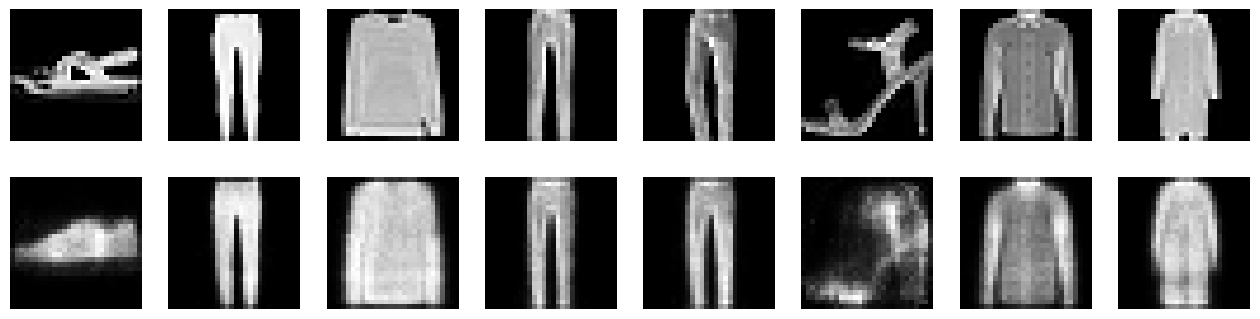

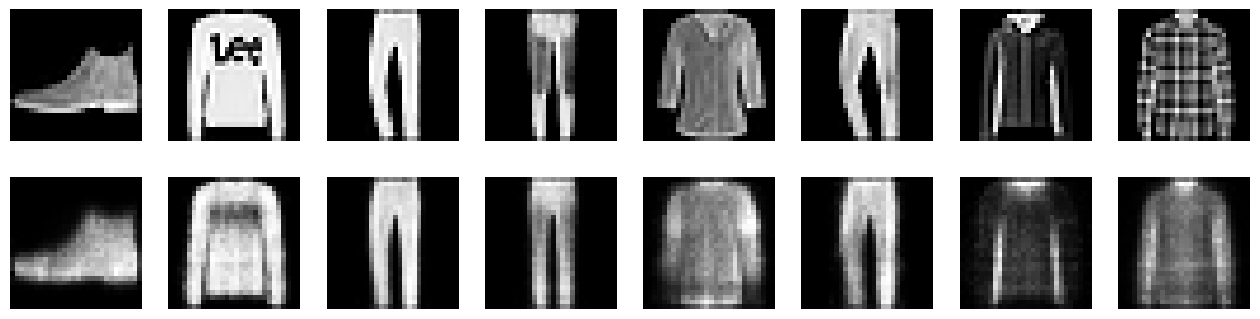

In [ ]:
# 48 Dim
auto_encoder_48 = init_params(latent_dim=48)
auto_encoder_48 = train(auto_encoder_48, train_loader, test_loader, epochs=20)
reconstruct(auto_encoder_48, train_loader, device=device)
reconstruct(auto_encoder_48, test_loader, device=device)

Fine grained information lost. The logo is missing. Overall shape and semantics is still preserved.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def linear_interpolation(params, loader, pairs=4, steps=5, title_prefix="Latent"):
    for k in params:
        params[k].data = params[k].data.to(device) # offload to gpu

    imgs, _ = next(iter(loader))
    imgs, _ = next(iter(loader)) # Taking a batch
    imgs = imgs.to(device)

    z_all = encode(imgs, params)

    for i in range(pairs):
        z1, z2 = z_all[2*i], z_all[2*i + 1] # Pick a pair
        fig, axes = plt.subplots(1, steps, figsize=(steps*1.8, 2))
        for j, a in enumerate(np.linspace(0, 1, steps)):
            z = (1-a)*z1 + a*z2 # Linear Interpolation
            y = decode(z.unsqueeze(0), params)      # [1,784]
            axes[j].imshow(y.view(28,28).cpu().detach().numpy(), cmap='gray') # Show image
            axes[j].axis('off')
        fig.suptitle(f"{title_prefix} Dim ― Pair #{i+1}")
        plt.show()

Interpolation for latent_dim = 16


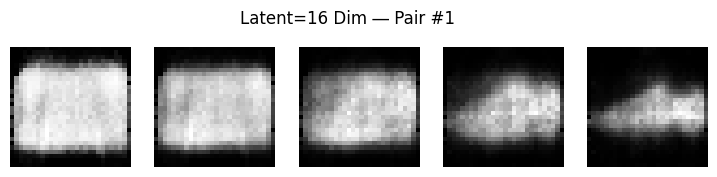

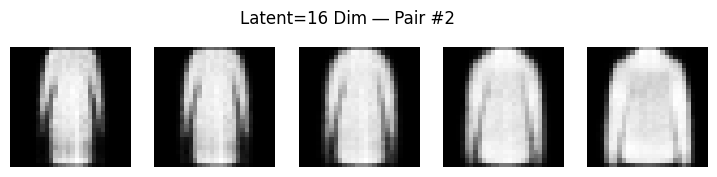

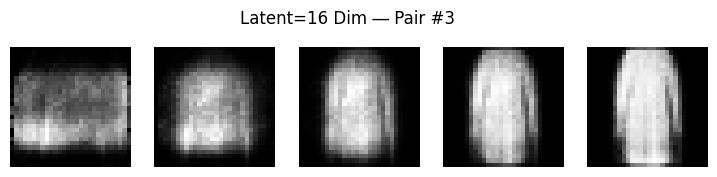

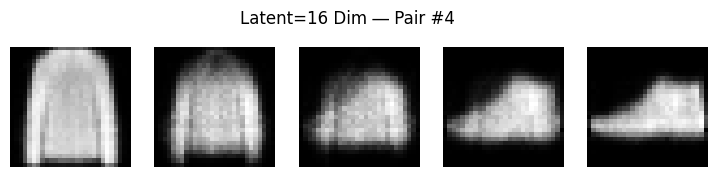

Interpolation for latent_dim = 48


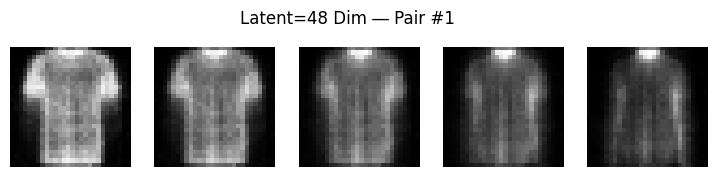

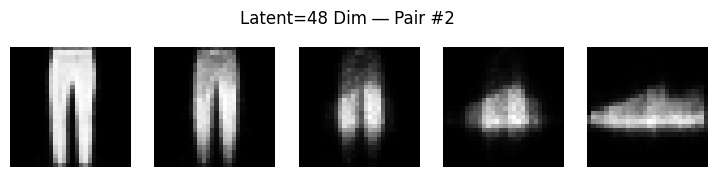

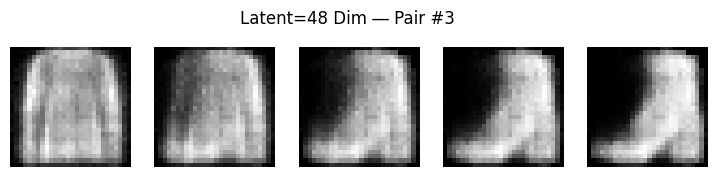

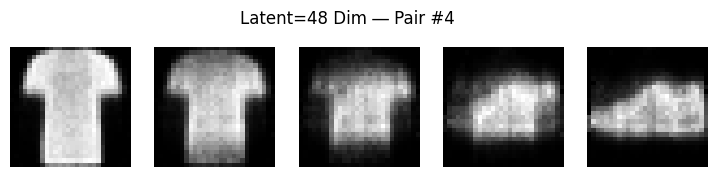

In [ ]:
print("Interpolation for latent_dim = 16")
linear_interpolation(auto_encoder_16, train_loader, pairs=4, steps=5, title_prefix="Latent=16")

print("Interpolation for latent_dim = 48")
linear_interpolation(auto_encoder_48, train_loader, pairs=4, steps=5, title_prefix="Latent=48")

At dimension 48 more fine grained information is obtained than in dimension 16.